<a href="https://colab.research.google.com/github/souravripunjay6/sourav_INFO5731_spring2022/blob/main/Amudala_Assignment_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **INFO5731 Assignment Three**

In this assignment, you are required to conduct information extraction, semantic analysis based on **the dataset you collected from assignment two**. You may use scipy and numpy package in this assignment.

In [1]:
!pip install transformers


import re
import os
import time
import pickle
import string
import unicodedata
import collections
import spacy
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, AdaBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import PCA
from sklearn.feature_selection import chi2
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline, make_pipeline
from collections import Counter
import nltk
from nltk.sentiment import SentimentAnalyzer
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import stopwords
from textblob import TextBlob
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from gensim.models import Word2Vec
from gensim.models.phrases import Phrases, Phraser
import transformers
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import warnings


nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('words')


warnings.simplefilter(action='ignore', category=FutureWarning)


/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!


In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/souravripunjay6/Reviews_segmentation/main/reviews_segmentation.csv')
df.rename(columns={'Description': 'Phrase'}, inplace=True)
df = df.iloc[:, 1:-1]
df.head()


,Phrase,Sentiment
0,Purchased this product advertised as fully unl...,Negative
1,I was feeling a bit skeptical after I placed m...,Positive
2,Phone was not unlocked could it use it,Negative
3,The screen came cracked and popped out of the ...,Negative
4,Be careful mine had a scratch on screen very s...,Negative


# **Question 1: Understand N-gram**

(45 points). Write a python program to conduct N-gram analysis based on the dataset in your assignment two:

(1) Count the frequency of all the N-grams (N=3).

(2) Calculate the probabilities for all the bigrams in the dataset by using the fomular count(w2 w1) / count(w2). For example, count(really like) / count(really) = 1 / 3 = 0.33.

(3) Extract all the **noun phrases** and calculate the relative probabilities of each review in terms of other reviews (abstracts, or tweets) by using the fomular frequency (noun phrase) / max frequency (noun phrase) on the whole dataset. Print out the result in a table with column name the all the noun phrases and row name as all the 100 reviews (abstracts, or tweets). 


In [3]:
# clean the reviews
stop = stopwords.words('english')
df.Phrase = df.Phrase.apply(lambda x: x.replace(r'"', ''))
df.Phrase = df.Phrase.apply(
    lambda x: x.replace(r'[\n\n\n\n\n\n\n\n\n\n  \n  \n    , \n  ', ''))
df.Phrase = df.Phrase.apply(
    lambda x: x.replace(r'\n, \n  \n]', ''))
df.Phrase = df.Phrase.apply(lambda x: x.lower())
df.Phrase = df.Phrase.apply(lambda x: re.sub(r'\w*\d', '', x))
df.Phrase = df.Phrase.str.replace('[^\w\s]', '')
df.Phrase = df.Phrase.apply(
    lambda x: ' '.join(x for x in x.split() if x not in stop))
df.head()

,Phrase,Sentiment
0,purchased product advertised fully unlocked in...,Negative
1,feeling bit skeptical placed order proven wron...,Positive
2,phone unlocked could use,Negative
3,screen came cracked popped frame hopefully ret...,Negative
4,careful mine scratch screen small still used p...,Negative


In [4]:
text = df.Phrase.values
text = ' '.join([review for review in text])



1. Count the frequency of all the N-grams (N=3)




In [5]:
def get_ngram(num):
  ngram_dict = {}

  for review in df.Phrase:
    ngram_list = TextBlob(review).ngrams(num)
    if(len(ngram_list) > 0):
      for ngram in ngram_list:
        ngram_key = tuple(ngram)
        if ngram_key in ngram_dict:
          ngram_dict[ngram_key] += 1
        else:
          ngram_dict[ngram_key] = 1
  return(ngram_dict)

ngram_num = 3
trigram_dict = get_ngram(ngram_num)
trigram = pd.DataFrame.from_dict(trigram_dict, orient='index', columns=['Frequency'])
trigram.sample(100)

,Frequency
"(bought, phone, months)",1
"(go, ahead, purchase)",1
"(phone, checking, sim)",1
"(contacted, service, provider)",1
"(comparison, sloppy, looked)",1
...,...
"(phone, used, visible)",1
"(headphone, jack, crucial)",1
"(says, internationally, unlocked)",1
"(left, reviews, reviews)",1


2. Calculate the probabilities for all the bigrams in the dataset by using the fomular count(w2 w1) / count(w2). For example, count(really like) / count(really) = 1 / 3 = 0.33.

In [6]:
bigram_dict = get_ngram(2)
unigram_dict = get_ngram(1)

bigram_prob = {}
for bigram in bigram_dict:
  word = tuple((bigram[0],))
  count_bi = bigram_dict[bigram]
  count_uni = unigram_dict[word]
  prob = count_bi / count_uni
  bigram_prob[bigram] = prob

bigram_df = pd.DataFrame.from_dict(bigram_prob, orient='index', columns=['Bi-grams Probability'])
print(bigram_df)

                       Bi-grams Probability
(purchased, product)               0.027778
(product, advertised)              0.015873
(advertised, fully)                0.090909
(fully, unlocked)                  0.625000
(unlocked, inserted)               0.014085
...                                     ...
(thats, well)                      0.043478
(well, charge)                     0.021277
(charge, holds)                    0.041667
(holds, im)                        0.250000
(really, glad)                     0.020000

[11704 rows x 1 columns]


(3) Extract all the noun phrases and calculate the relative probabilities of each review in terms of other reviews (abstracts, or tweets) by using the fomular frequency (noun phrase) / max frequency (noun phrase) on the whole dataset. Print out the result in a table with column name the all the noun phrases and row name as all the 100 reviews (abstracts, or tweets).

In [7]:
nlp = spacy.load("en")
df[["Phrase"]].to_csv('train.csv',index=False)
file = open('train.csv', 'r', encoding='latin-1')
data_file2 = nlp(file.read())
noun_phrases = []
for noun in data_file2.noun_chunks:
  noun_phrases.append(noun.text)
print(noun_phrases)
np_result = pd.DataFrame(noun_phrases, columns = ['noun_phrases'])
vector = CountVectorizer(ngram_range=(3,3), analyzer='word')
transform1 = vector.fit_transform(np_result['noun_phrases'].values.astype('U')) 
frequency = sum(transform1).toarray()[0]
npp_result = pd.DataFrame(frequency, index=vector.get_feature_names(), columns=['noun_phrases_Frequency'])
npp_result['noun_phrases_Probabilities'] = npp_result / npp_result.max()
npp_result.sample(100)

['Phrase', 'product', 'fully unlocked inserted sim card work contacted service provider', 'imei number', 'phone', 'good condition', 'service provider', 'feeling bit skeptical placed order', 'minimal light', 'almost impossible notice battery life', 'screen', 'popped frame hopefully return process', 'people', 'used phones', 'best experience', 'renewed phone phone', 'original box original charger cable phone', 'excellent one scratch', 'absolutely beautiful battery health', 'seller gooverstock', 'longest time', 'upgraded iphone iphone', 'places online price way price point', 'comfortable buying phone amazon', 'box', 'ear phones phone', 'set apps', 'wanna', 'everybody', 'scam phone', 'amazing great battery life', 'i', 'everything', 'iphone box', 'charger', 'phone', 'reviews', 'brand', 'new unlocked', 'i', 'm paired cricket', 'everything', 'new\niphone', 'big scuff corner aluminum frame', 'small really noticible scratch front back phone', 'product red unlocked iphone', 'verizon unlocked phon

,noun_phrases_Frequency,noun_phrases_Probabilities
nice phone excellent,1,0.142857
box phone work,1,0.142857
covid protection mask,1,0.142857
im glad phone,1,0.142857
happy quality phone,1,0.142857
...,...,...
original apple brick,1,0.142857
im lol phone,1,0.142857
vez tiene unos,1,0.142857
renewed phone awesome,1,0.142857


# **Question 2: Undersand TF-IDF and Document representation**

(40 points). Starting from the documents (all the reviews, or abstracts, or tweets) collected for assignment two, write a python program: 

(1) To build the **documents-terms weights (tf*idf) matrix bold text**.

(2) To rank the documents with respect to query (design a query by yourself, for example, "An Outstanding movie with a haunting performance and best character development") by using **cosine similarity**.

To build the documents-terms weights (tf*idf) matrix bold text.

In [8]:
train, test = train_test_split(
    df[["Phrase", "Sentiment"]], random_state=0)
X_train = train.Phrase
X_test = test.Phrase
y_train = train.Sentiment
y_test = test.Sentiment


In [9]:
def get_accuracy():
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    return round(accuracy_score(y_pred, y_test), 3)


# Baseline models
We'll build them through simple steps:

encoding each sentence through basic methods such as bag of words and tf-idf.
using classic trees ensembles that use bagging and boosting, respectively.
ignoring the sentence Id.
ignoring in some cases the less frequent words.

## Random Forest, BOW, TF-IDF

In [10]:
count_vectorizer = CountVectorizer(max_features=1000)
random_forest = RandomForestClassifier(max_depth=10, n_estimators=10)


In [11]:
pipe = make_pipeline(count_vectorizer, random_forest)


In [12]:
get_accuracy()


0.744

Let's look at the percentages of the classes in the true labels and in the predictions.

In [13]:
y_pred = pipe.predict(X_test)


In [14]:
round(pd.Series(y_train).value_counts(normalize=True), 3)


Positive                                                                                                                                             0.624
Negative                                                                                                                                             0.301
Neutral                                                                                                                                              0.072
t dilike the product i dislike the fact that this was taken out my account and no one notifed me that this large amount was coming out my account    0.003
Name: Sentiment, dtype: float64

In [15]:
round(pd.Series(y_pred).value_counts(normalize=True), 3)


Positive    0.896
Negative    0.104
dtype: float64

As we can see, Decision Trees in their basic configuration are not a good model for unbalanced data! In almost every node, the biggest category has the majority and that's what the model predicts for almost every row. The accuracy then is aproximately the percentage of the biggest category: 0.5.

Let's add now weights.

In [16]:
random_forest.set_params(class_weight='balanced')
print(get_accuracy())
random_forest.set_params(class_weight='balanced_subsample')
print(get_accuracy())


0.696
0.696


Surprisingly or not, when using as weights the inverse of the classes proportion, the accuracy gets worst.

Through the confusion matrix we can see that the model is still predicting too much 2, although now the complexity increased.

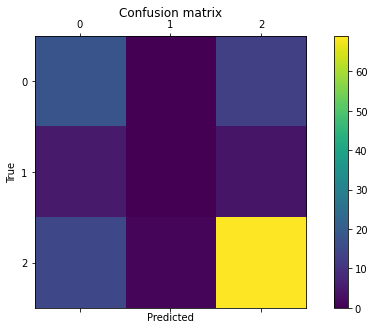

In [17]:
labels = [0, 1, 2]
y_pred = pipe.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


We'll try also adding lemmatization and replacing the BOW with tf-idf.

In [18]:
# taken from sklearn webpage
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer


class LemmaTokenizer:
    def __init__(self):
        self.wnl = WordNetLemmatizer()

    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc)]


In [19]:
pipe[0].set_params(tokenizer=LemmaTokenizer())
get_accuracy()


0.704

In [20]:
tfidf_vectorizer = TfidfVectorizer()
pipe.steps[0] = ('vectorizer', tfidf_vectorizer)
get_accuracy()


0.664

That is, still poor results. We'll try with boosting.

# Adaboost, chi2

In [21]:
ada_boost = AdaBoostClassifier()
pipe.steps[1] = ('adaboost', ada_boost)
get_accuracy()


0.632

We now see an improvement. We'll try now using only the most relevant words according to chi2.

In [22]:
count_vectorizer.get_feature_names


<bound method CountVectorizer.get_feature_names of CountVectorizer(max_features=1000,
                tokenizer=<__main__.LemmaTokenizer object at 0x7f30052c10d0>)>

In [23]:
count_vectorizer = CountVectorizer(max_features=1000)

bow = count_vectorizer.fit_transform(X_train)

words = count_vectorizer.get_feature_names()

p_value_limit = 0.95

dtf_features = pd.DataFrame()

for cat in range(3):
    _, p = chi2(bow, y_train == cat)
    dtf_features = dtf_features.append(pd.DataFrame(
        {"feature": words, "score": 1-p, "y": cat}))
    dtf_features = dtf_features.sort_values(["y", "score"],
                                            ascending=[True, False])
    # dtf_features = dtf_features[dtf_features["score"] > p_value_limit]

X_names = dtf_features["feature"].unique().tolist()

pipe['vectorizer'].set_params(vocabulary=X_names)

get_accuracy()


0.648

# Neural networks

We'll use a simple NN with only one hidden layer.

In [24]:
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy',
                     mode='max', verbose=1, save_best_only=True)


In [25]:
def fit_sequential(X_train, X_test, sequential=None, epochs=20, patience=5):

    if sequential is None:
        input_size = X_train.shape[1]

        sequential = tf.keras.models.Sequential([
            tf.keras.layers.Flatten(input_shape=(input_size, )),
            tf.keras.layers.Dense(128),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(3, activation='sigmoid')
        ])
        loss_fn = tf.keras.losses.CategoricalCrossentropy(
            from_logits=True)
        sequential.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
                           metrics=['accuracy'])
        global mc
        mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy',
                             mode='max', verbose=1, save_best_only=True)

    es = EarlyStopping(monitor='val_accuracy', mode='max',
                       verbose=1, patience=patience)
    sequential.fit(X_train, np.array(y_train), epochs=epochs, verbose=1,
                   validation_data=(X_test, np.array(y_test)), callbacks=[es, mc])
    sequential.load_weights('best_model.h5')
    return sequential


In [26]:
sentiment_mapper = {'Negative': 0, 'Positive': 1, 'Neutral': 2}
df.Sentiment = df.Sentiment.map(sentiment_mapper)
df = df[df.Sentiment < 3.0]
print(df.head())
train, test = train_test_split(
    df, random_state=0)
X_train = train.Phrase
X_test = test.Phrase
y_train = train.Sentiment
y_test = test.Sentiment

                                              Phrase  Sentiment
0  purchased product advertised fully unlocked in...        0.0
1  feeling bit skeptical placed order proven wron...        1.0
2                           phone unlocked could use        0.0
3  screen came cracked popped frame hopefully ret...        0.0
4  careful mine scratch screen small still used p...        0.0


## Using tf–idf

In [27]:
vectorizer = TfidfVectorizer()


In [28]:
def convert_sparse_matrix_to_sparse_tensor(X):
    coo = X.tocoo()
    indices = np.mat([coo.row, coo.col]).transpose()
    return tf.sparse.reorder(tf.SparseTensor(indices, coo.data, coo.shape))


In [29]:
X_train_vectorized = vectorizer.fit_transform(X_train).toarray()
X_test_vectorized = vectorizer.transform(X_test).toarray()


In [30]:
sequential = fit_sequential(X_train_vectorized, X_test_vectorized)


Epoch 1/20
12/12 [==============================] - ETA: 0s - loss: 1.0175 - accuracy: 0.6150
Epoch 1: val_accuracy improved from -inf to 0.65600, saving model to best_model.h5
12/12 [==============================] - 2s 63ms/step - loss: 1.0175 - accuracy: 0.6150 - val_loss: 0.9135 - val_accuracy: 0.6560
Epoch 2/20
10/12 [========================>.....] - ETA: 0s - loss: 0.8195 - accuracy: 0.6625
Epoch 2: val_accuracy did not improve from 0.65600
12/12 [==============================] - 0s 21ms/step - loss: 0.8096 - accuracy: 0.6631 - val_loss: 0.7804 - val_accuracy: 0.6560
Epoch 3/20
12/12 [==============================] - ETA: 0s - loss: 0.6695 - accuracy: 0.6631
Epoch 3: val_accuracy did not improve from 0.65600
12/12 [==============================] - 0s 20ms/step - loss: 0.6695 - accuracy: 0.6631 - val_loss: 0.7083 - val_accuracy: 0.6560
Epoch 4/20
 9/12 [=====================>........] - ETA: 0s - loss: 0.5593 - accuracy: 0.7778
Epoch 4: val_accuracy improved from 0.65600 to 0.

# **Question 3: Create your own word embedding model**

(20 points). Use the data you collected for assignment two to build a word embedding model: 

(1) Train a 300-dimension word embedding (it can be word2vec, glove, ulmfit, bert, or others).

(2) Visualize the word embedding model you created.

Reference: https://machinelearningmastery.com/develop-word-embeddings-python-gensim/

## Using Word2vec

In [31]:
class W2VTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, size):
        self.size = size
        pass

    def fit(self, X, y=None):
        self.model = Word2Vec(min_count=1,
                              window=2,
                              size=self.size,
                              sample=6e-5,
                              alpha=0.03,
                              min_alpha=0.0007,
                              negative=20)
        sentences = [row.split() for row in X]

        self.model.build_vocab(sentences)
        self.model.train(
            sentences, total_examples=self.model.corpus_count, epochs=self.model.epochs)
        return self

    def get_vector(self, sentence):
        relevant_words_vectors = [self.model.wv[x]
                                  for x in sentence.split() if x in self.model.wv.vocab]
        if not relevant_words_vectors:
            return np.zeros(self.model.vector_size)  # .astype('float32')
        return np.mean(relevant_words_vectors, axis=0)

    def transform(self, X):
        arr = np.array([])
        for elem in X:
            arr = np.concatenate([arr, self.get_vector(elem)])
        return arr.reshape(-1, self.size)


In [32]:
vectorizer = W2VTransformer(4)
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)


In [33]:
sequential = fit_sequential(X_train_vectorized, X_test_vectorized)


Epoch 1/20
 1/12 [=>............................] - ETA: 9s - loss: 1.0384 - accuracy: 0.5938
Epoch 1: val_accuracy improved from -inf to 0.65600, saving model to best_model.h5
12/12 [==============================] - 1s 41ms/step - loss: 0.9728 - accuracy: 0.6310 - val_loss: 0.8782 - val_accuracy: 0.6560
Epoch 2/20
 1/12 [=>............................] - ETA: 0s - loss: 0.8385 - accuracy: 0.7188
Epoch 2: val_accuracy did not improve from 0.65600
12/12 [==============================] - 0s 9ms/step - loss: 0.8849 - accuracy: 0.6337 - val_loss: 0.8216 - val_accuracy: 0.6560
Epoch 3/20
 1/12 [=>............................] - ETA: 0s - loss: 0.9798 - accuracy: 0.5000
Epoch 3: val_accuracy did not improve from 0.65600
12/12 [==============================] - 0s 12ms/step - loss: 0.8537 - accuracy: 0.6337 - val_loss: 0.8046 - val_accuracy: 0.6560
Epoch 4/20
11/12 [==========================>...] - ETA: 0s - loss: 0.8575 - accuracy: 0.6307
Epoch 4: val_accuracy did not improve from 0.65600

In [34]:
pca = PCA(n_components=2)
X_train_vectorized_2d = pca.fit_transform(X_train_vectorized)


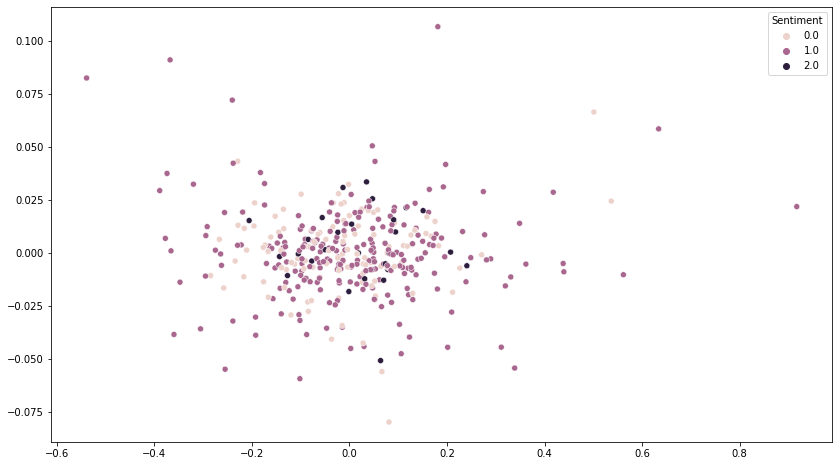

In [35]:
plt.figure(figsize=(14, 8))
_ = sns.scatterplot(
    X_train_vectorized_2d[:, 0], X_train_vectorized_2d[:, 1], hue=y_train)


Even though the scatterplot is not showing us the "neutral" points we can see that indeed there is not much of a separation between the classes

with the same preprocessing as before but using a neural network, the results are slightly better. It looks like we need to change the preprocessing in such a way that we start using the order between the words. A very first simple method, before we try more complex stuff like Word2Vec or LDA, would be adding 2-grams.

## Using BERT

In [36]:
model_class, tokenizer_class, pretrained_weights = (
    transformers.DistilBertModel, transformers.DistilBertTokenizer, 'distilbert-base-uncased')
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [37]:
kaggle_test = df

all_sentences = X_train.append([X_test, kaggle_test.Phrase])

tokenized = all_sentences.apply(
    lambda x: tokenizer.encode(x, add_special_tokens=True))

max_len = max(tokenized.apply(len))
padded = np.array([row + [0]*(max_len-len(row)) for row in tokenized])

attention_mask = np.where(padded != 0, 1, 0)

input_ids = torch.tensor(padded)
input_ids = torch.tensor(input_ids).to(torch.int64)

attention_mask = torch.tensor(attention_mask)

vector_length = model(input_ids[:1], attention_mask=attention_mask[:1])[
    0].shape[2]

vectors = np.zeros(shape=(0, vector_length))


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


We're using an already trained version of distilBERT. In order to create the embedding, this has to be done in batches. For example through the below function:

In [38]:
def get_vectors():
    start = time.time()
    k = 1000
    for i in range(0, len(all_sentences), k):
        with torch.no_grad():
            last_hidden_states = model(
                input_ids[i:i+k], attention_mask=input_ids[i:i+k])
        vectors = np.concatenate([vectors, last_hidden_states[0].numpy(
        )[:, 0, :]]) if i > 0 else last_hidden_states[0].numpy()[:, 0, :]
    return vectors


Doing so in a CPU can be highly time consuming (A way of speeding it up could be to use much less precision-numbers). I already saved the data.

In [39]:
if os.path.isfile("bert_vectors.csv"):
    bert_vectors_df = pd.read_csv("bert_vectors.csv")
    vectors = bert_vectors_df.iloc[:, 1:]
elif os.path.isfile("bert_vectors.pickle"):
    with open('bert_vectors.pickle', 'rb') as handle:
        vectors = pickle.load(handle)
else:
    vectors = get_vectors()
    with open('bert_vectors.pickle', 'wb') as handle:
        pickle.dump(vectors, handle)


In [40]:
X_train_vectorized = vectors[:len(X_train)]
X_test_vectorized = vectors[len(X_train):len(X_train)+len(X_test)]
kaggle_test_vectorized = vectors[len(X_train)+len(X_test):]


# **Question 4: Create your own training and evaluation data for sentiment analysis**

(15 points). **You dodn't need to write program for this question!** Read each review (abstract or tweet) you collected in detail, and annotate each review with a sentiment (positive, negative, or neutral). Save the annotated dataset into a csv file with three columns (first column: document_id, clean_text, sentiment), upload the csv file to GitHub and submit the file link blew. This datset will be used for assignment four: sentiment analysis and text classification. 


In [41]:
sequential = fit_sequential(X_train_vectorized, X_test_vectorized, epochs=10)


Epoch 1/10
 1/12 [=>............................] - ETA: 10s - loss: 1.6810 - accuracy: 0.0625
Epoch 1: val_accuracy improved from -inf to 0.59200, saving model to best_model.h5
12/12 [==============================] - 1s 47ms/step - loss: 1.1098 - accuracy: 0.5160 - val_loss: 0.9749 - val_accuracy: 0.5920
Epoch 2/10
11/12 [==========================>...] - ETA: 0s - loss: 0.9027 - accuracy: 0.5852
Epoch 2: val_accuracy did not improve from 0.59200
12/12 [==============================] - 0s 12ms/step - loss: 0.9106 - accuracy: 0.5722 - val_loss: 0.9549 - val_accuracy: 0.4640
Epoch 3/10
 9/12 [=====================>........] - ETA: 0s - loss: 0.8541 - accuracy: 0.6250
Epoch 3: val_accuracy improved from 0.59200 to 0.64800, saving model to best_model.h5
12/12 [==============================] - 0s 14ms/step - loss: 0.8355 - accuracy: 0.6364 - val_loss: 0.8564 - val_accuracy: 0.6480
Epoch 4/10
 1/12 [=>............................] - ETA: 0s - loss: 0.8988 - accuracy: 0.6562
Epoch 4: val_

In [42]:
vectorizer = W2VTransformer(4)
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)
sequential = fit_sequential(X_train_vectorized, X_test_vectorized)


def get_sentiment(model, vectorizer, mapper, text):
    return mapper.get(np.argmax(max(model.predict(vectorizer.transform(pd.Series([text]))))))


Epoch 1/20
 1/12 [=>............................] - ETA: 9s - loss: 1.1409 - accuracy: 0.1250
Epoch 1: val_accuracy improved from -inf to 0.65600, saving model to best_model.h5
12/12 [==============================] - 1s 34ms/step - loss: 1.0628 - accuracy: 0.4626 - val_loss: 0.9653 - val_accuracy: 0.6560
Epoch 2/20
 1/12 [=>............................] - ETA: 0s - loss: 0.9155 - accuracy: 0.8125
Epoch 2: val_accuracy did not improve from 0.65600
12/12 [==============================] - 0s 9ms/step - loss: 0.9347 - accuracy: 0.6337 - val_loss: 0.8653 - val_accuracy: 0.6560
Epoch 3/20
 1/12 [=>............................] - ETA: 0s - loss: 0.8301 - accuracy: 0.6875
Epoch 3: val_accuracy did not improve from 0.65600
12/12 [==============================] - 0s 11ms/step - loss: 0.8766 - accuracy: 0.6337 - val_loss: 0.8244 - val_accuracy: 0.6560
Epoch 4/20
 1/12 [=>............................] - ETA: 0s - loss: 0.7670 - accuracy: 0.6875
Epoch 4: val_accuracy did not improve from 0.65600

In [43]:
get_sentiment(sequential, vectorizer, sentiment_mapper, "The new big one is huge")


Firstly we are using random forest We build them in simple steps. After loading the CSV file, splitting the data into X train, x_test, y_train and y_test. CountVectorizer function is used to convert the text data into numercial data.
encoding each sentence with simple techniques such as bag of words and tf-idf Traditional tree ensembles with bagging and boosting are used. 

Random Forest and AdaBoost algorithms are both based on the creation of a forest of trees. These are referred to as ensemble learning algorithms. A random forest is created by combining a number of decision trees that use various variables or features and bagging techniques for data sampling. The AdaBoost algorithm is said to make decisions by employing a slew of decision stumps.

AdaBoost is a machine learning algorithm that may be used to improve the performance of any other machine learning technique. It works well with students who are struggling. Decision trees with one level are the most suitable and hence most commonly used algorithm with AdaBoost.

While coming to the other models TfIdf,  Word2Vec and BERT we are using neural network to which we are passing vector input and flattening it an then we are adding a dense layer with 128 logits and then using dropout layer and then we are adding a dense layer with softmax activation and logits equal to number of classes